# Overlapping phytochemicals (natural products in plants) with approved-drugs (Newman dataset)

### Import modules

In [1]:
from collections import defaultdict
import os

import pandas as pd
from tqdm import tqdm
import seaborn as sns

from rdkit import RDLogger
from rdkit.Chem.inchi import MolToInchi, InchiToInchiKey
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Descriptors import ExactMolWt

from pubchempy import get_compounds, Compound

import matplotlib as mpl
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

In [2]:
%config Application.log_level='INFO'
import logging
logging.getLogger('s3fs').setLevel(logging.INFO)
logging.getLogger('botocore').setLevel(logging.INFO)
logging.getLogger('fsspec').setLevel(logging.INFO)

In [3]:
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 360

In [4]:
%matplotlib inline

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [5]:
RDLogger.DisableLog("rdApp.*")

In [6]:
DATA_DIR = "../data/"

In [7]:
def get_first_part_inchikey(inchikey):
    return inchikey.split("-")[0]

Load Newman data

In [8]:
# This data is processed from the supplementary table of the Newman paper
natural_products_df = pd.read_csv(
    "../data/newman_natural_products.tsv",
    sep="\t",
    usecols=[
        "curated_name",
        "pubchem_name",
        "pubchem_id",
        "smiles",
    ],
)

synthetics_df = pd.read_csv(
    "../data/newman_synthetics.tsv",
    sep="\t",
    usecols=[
        "curated_name",
        "pubchem_name",
        "pubchem_id",
        "smiles",
    ],
)

inchikey_to_pubchem_newman_nps = {}

for pubchem_id, smiles in tqdm(natural_products_df[["pubchem_id", "smiles"]].values):
    inchikey_to_pubchem_newman_nps[
        get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles))))
    ] = pubchem_id

100%|██████████| 360/360 [00:00<00:00, 2245.34it/s]


In [9]:
natural_products_df.shape, synthetics_df.shape

((360, 4), (927, 4))

In [10]:
synthetics_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,alizapride,6-methoxy-N-[(1-prop-2-enylpyrrolidin-2-yl)met...,135413504,COC1=CC2=C(C=C1C(=O)NCC3CCCN3CC=C)NN=N2
1,amezinium methylsulfate,6-methoxy-1-phenylpyridazin-1-ium-4-amine;meth...,71926,COC1=[N+](N=CC(=C1)N)C2=CC=CC=C2.COS(=O)(=O)[O-]


In [11]:
natural_products_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,aclarubicin,"methyl (1R,2R,4S)-4-[(2R,4S,5S,6S)-4-(dimethyl...",451415,CC[C@]1(C[C@@H](C2=C(C3=C(C=C2[C@H]1C(=O)OC)C(...
1,Netilmicin sulfate,"(2R,3R,4R,5R)-2-[(1S,2S,3R,4S,6R)-4-amino-3-[[...",62115,CCN[C@@H]1C[C@@H]([C@H]([C@@H]([C@H]1O[C@@H]2[...


In [12]:
smiles_in_data = set(natural_products_df.smiles.unique()).union(
    set(synthetics_df.smiles.unique())
)
len(smiles_in_data)

1268

In [13]:
all_inchikeys = {}
skipped = 0

low_molecular_weights = []

molecular_weights = []

for smiles in tqdm(smiles_in_data):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    mol_weight = ExactMolWt(mol)

    molecular_weights.append(mol_weight)

    if mol_weight < 150:
        low_molecular_weights.append(smiles)

    all_inchikeys[get_first_part_inchikey(InchiToInchiKey(MolToInchi(mol)))] = mol

100%|██████████| 1268/1268 [00:00<00:00, 3092.72it/s]


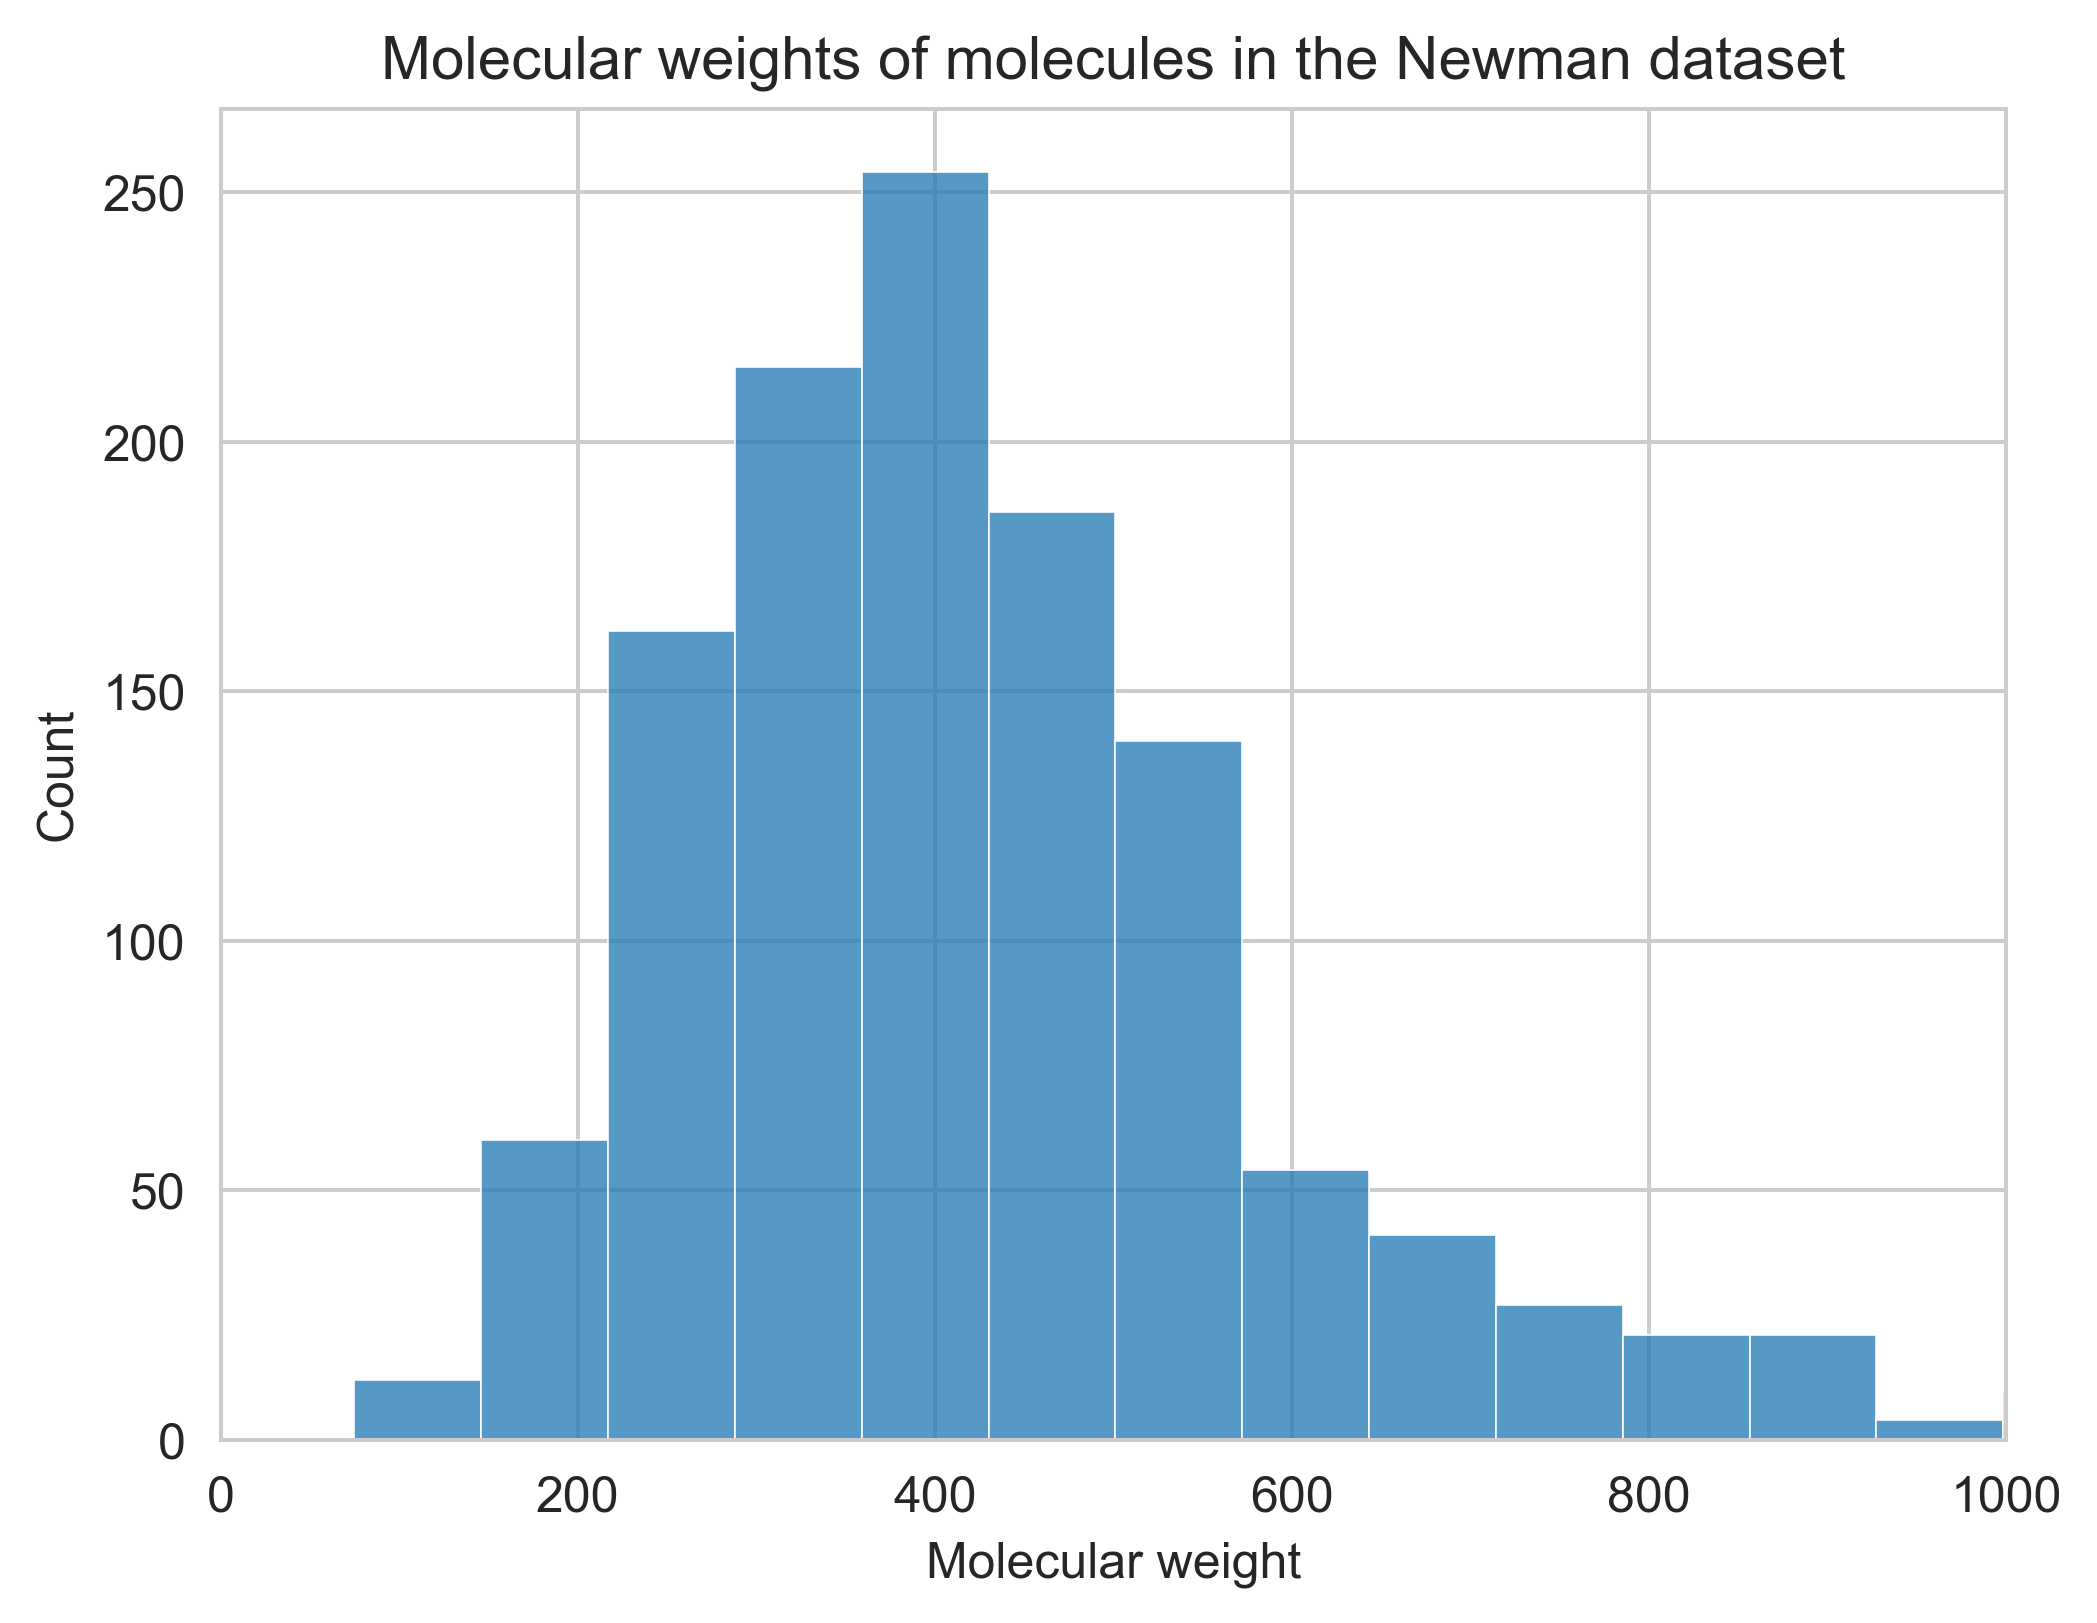

In [14]:
sns.histplot(molecular_weights, bins=100)
plt.title("Molecular weights of molecules in the Newman dataset")
plt.xlabel("Molecular weight")
plt.xlim(0, 1000)
plt.show()

In [15]:
len(all_inchikeys)

1268

This dataset requires an approved license and cant be released by us so this step is not reproducible and the dataset has to be downloaded manually

In [16]:
# Downloaded from https://go.drugbank.com/releases/latest#open-data
# This data requires an approved license and cant be released by us so this step is not reproducible
drugbank_approved_df = PandasTools.LoadSDF(
    "../data/drugbank_approved.sdf",
    smilesName="SMILES",
    molColName="Molecule",
)

In [17]:
drugbank_approved_df.shape[0]

2587

In [18]:
molecular_weights = []

for smiles in tqdm(drugbank_approved_df.SMILES):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    molecular_weights.append(ExactMolWt(mol))

100%|██████████| 2587/2587 [00:00<00:00, 11005.00it/s]


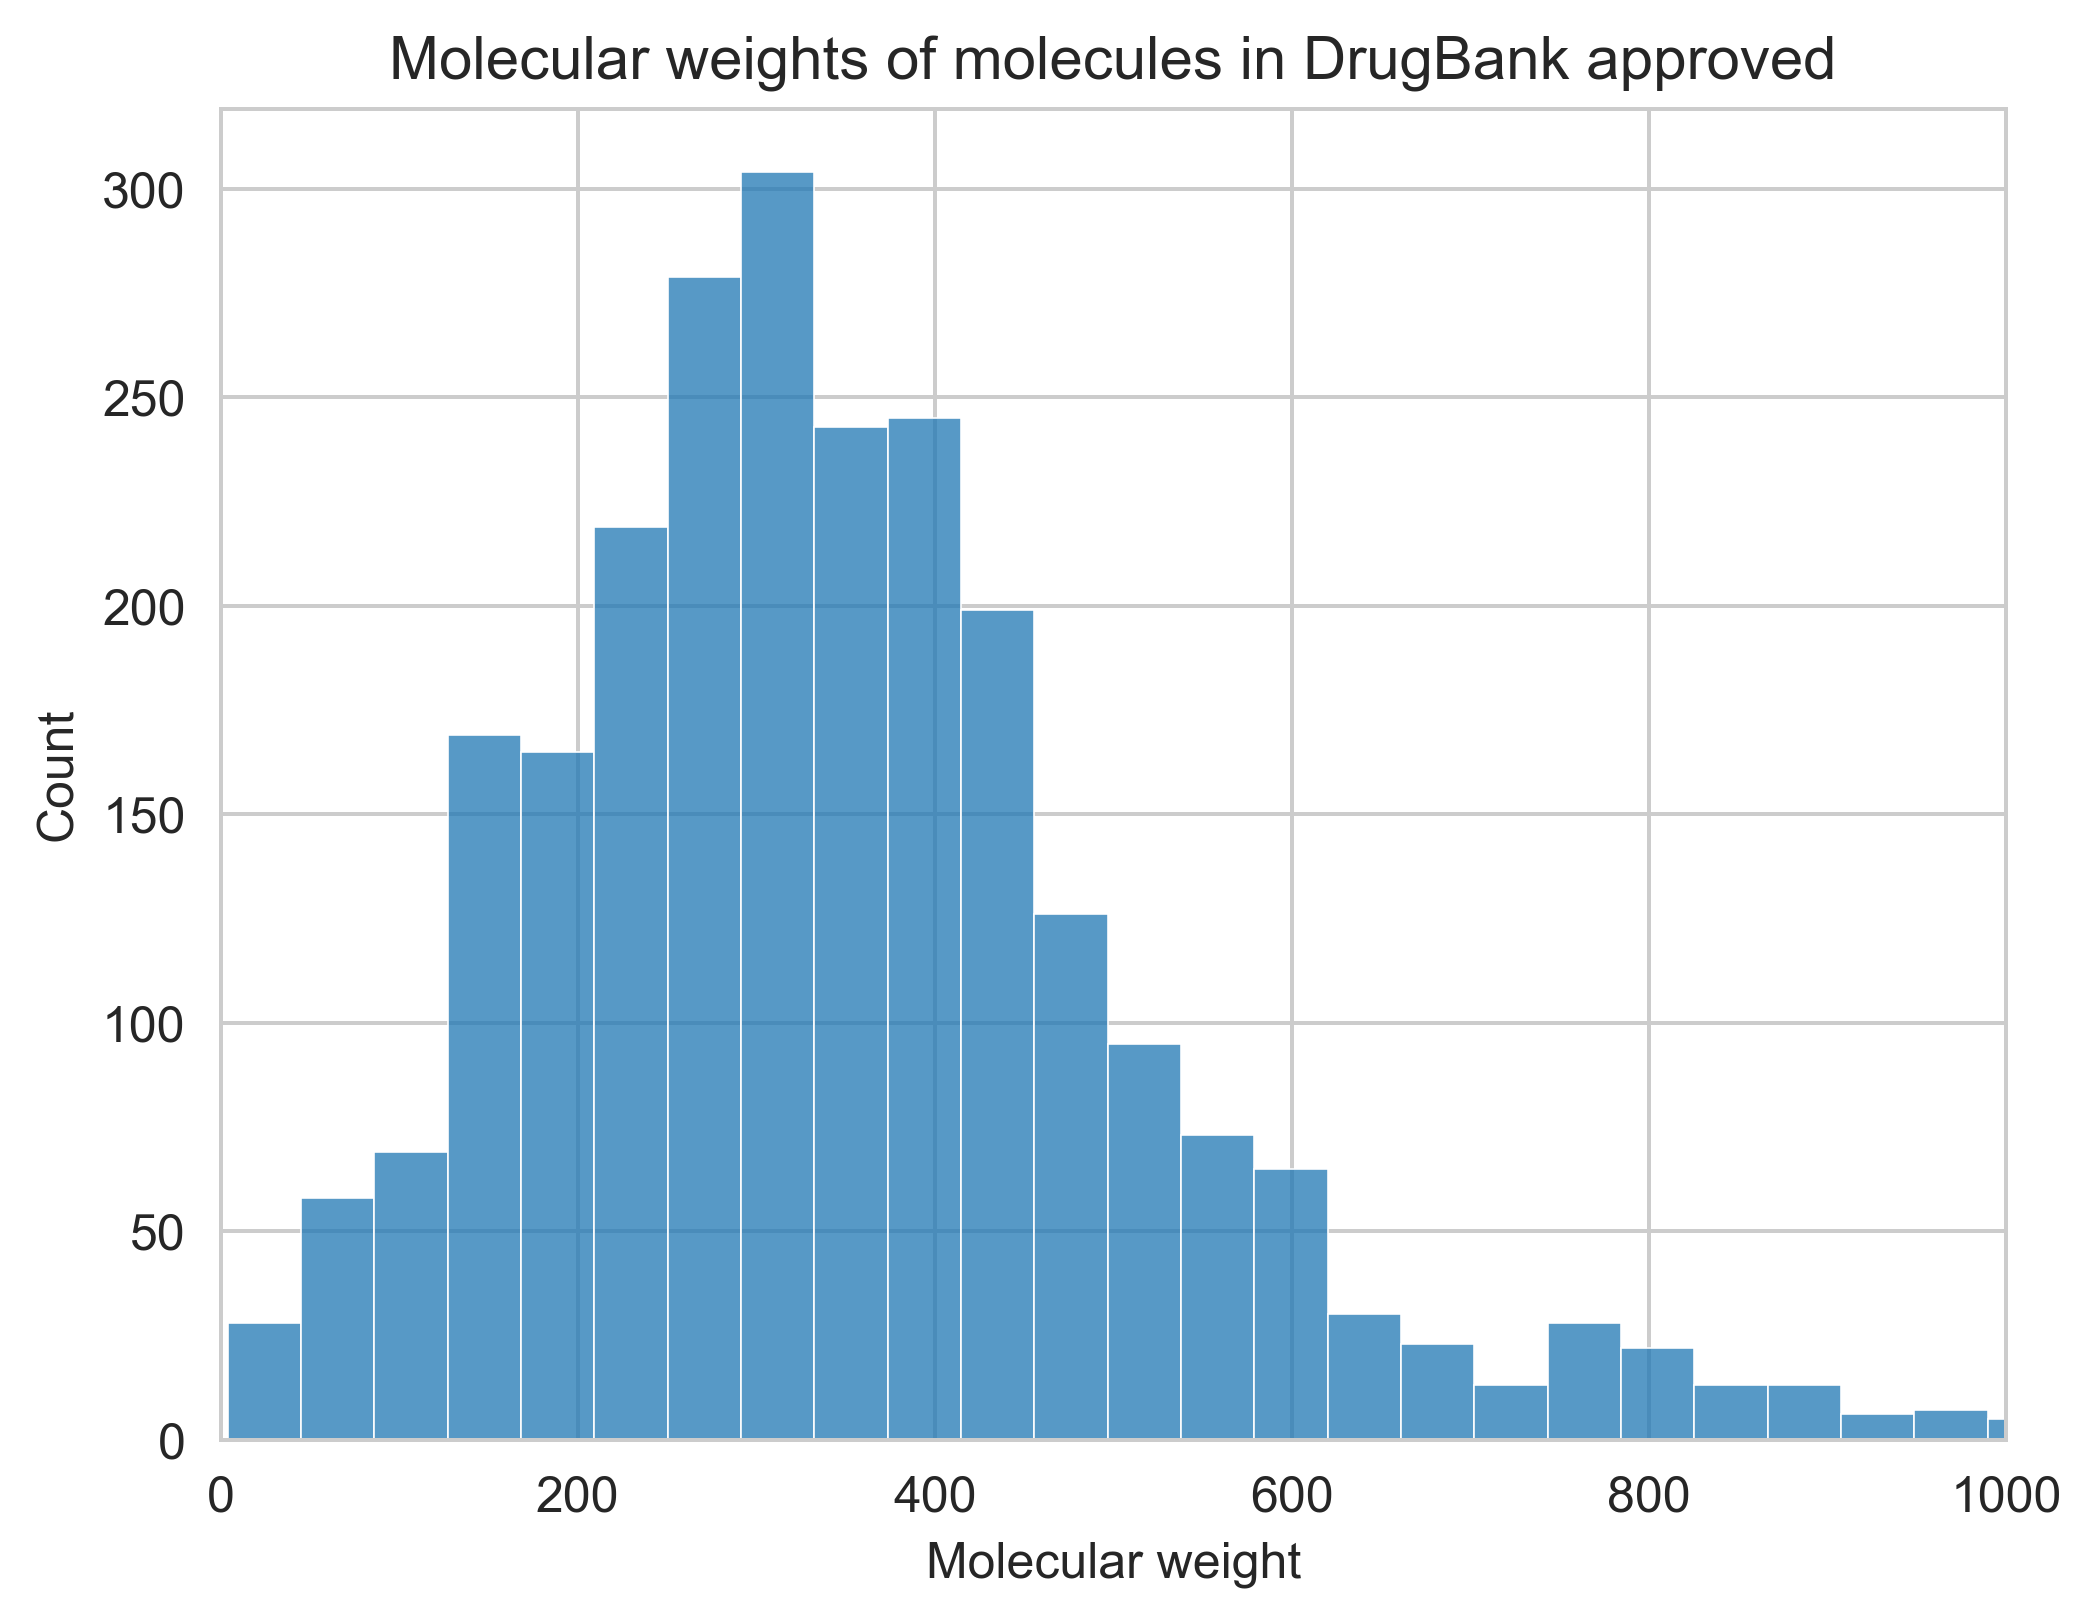

In [19]:
sns.histplot(molecular_weights, bins=100)
plt.title("Molecular weights of molecules in DrugBank approved")
plt.xlabel("Molecular weight")
plt.xlim(0, 1000)
plt.show()

### Load ethnobotanical data

In [20]:
plant_disease_df = pd.read_csv(
    "https://github.com/enveda/ethnobotany/raw/main/data/processed/plant_disease_associations.tsv.gz",
    compression="gzip",
    sep="\t",
)

medicinal_plants = plant_disease_df.plant_curie.unique()

In [21]:
plant_disease_df.shape[0], len(medicinal_plants)

(97066, 6048)

### Load phytochemical data

In [22]:
# Load Plant to PubChem
plant_chemical_df = pd.read_csv(
    "https://github.com/enveda/ethnobotany/raw/main/data/processed/plant_chemical_associations.tsv.zip",
    compression="zip",
    sep="\t",
    usecols=[
        "plant_curie",
        "chemical_curie",
    ],
)

# Load PubChem to SMILES
smiles_df = pd.read_csv(
    os.path.join(DATA_DIR, "smiles.tsv.zip"),
    sep="\t",
    compression="zip",
)

pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
    if pubchem_id.startswith("pubchem:"):
        pubchem_id = pubchem_id.replace("pubchem:", "pubchem.compound:")

    if pubchem_id not in chemicals_in_plants:
        continue

    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {smiles: pubchem for pubchem, smiles in pubchem_to_smiles.items()}

100%|██████████| 323369/323369 [00:00<00:00, 1235309.34it/s]


In [23]:
len(smiles_to_pubchem), plant_chemical_df.shape[0], len(
    plant_chemical_df.plant_curie.unique()
)

(69954, 330655, 18094)

#### InchiKey overlap

In [24]:
pubchem_to_inchikey = {
    pubchem: InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))
    for pubchem, smiles in tqdm(pubchem_to_smiles.items())
}

synthethics_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(synthetics_df[["curated_name", "smiles"]].values)
    if smiles not in low_molecular_weights
}

100%|██████████| 927/927 [00:00<00:00, 3547.66it/s]


In [25]:
coconut_smiles = pd.read_csv(
    "https://coconut.naturalproducts.net/download/smiles",
    names=["smiles"],
    header=None,
)

lotus_smiles = pd.read_csv(
    "https://lotus.naturalproducts.net/download/smiles",
    names=["smiles"],
    header=None,
)

In [26]:
natural_products_smiles = set(lotus_smiles.smiles.unique()).union(
    set(coconut_smiles.smiles.unique())
)

In [27]:
len(natural_products_smiles)

683788

In [28]:
all_natural_products_inchikeys = set()

skipped = set()

for smiles in tqdm(natural_products_smiles):
    try:
        mol = MolFromSmiles(smiles)
    except:
        continue

    # Skip if there are errors while reading the molecule
    try:
        inchikey = InchiToInchiKey(MolToInchi(mol))
    except:
        skipped.add(smiles)
        continue

    all_natural_products_inchikeys.add(get_first_part_inchikey(inchikey))

100%|██████████| 683788/683788 [03:15<00:00, 3493.92it/s]


In [29]:
len(skipped)

351

In [30]:
# PubChems that are duplicated or are not phytochemicals
# Found after manual curation to have a conservative estimate
blacklisted_pubchems = """5281004
31703
451415
262961
5486971
20058
53232
446284
5881
32756
25476
5282381
5281078
4603
444036
54687
10133
4330618
104741
3034010
4739
41774
104838
5362065"""

blacklisted_newman = """51634
5283734
5312153
65157
68921"""

In [31]:
synthethics_inchikeys = {inchikey for inchikey in synthethics_inchikeys_dict}

# Get the inchikeys of the natural products that are in LOTUS or COCONUT
natural_products_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(natural_products_df[["curated_name", "smiles"]].values)
    if smiles not in low_molecular_weights
    and get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles))))
    in all_natural_products_inchikeys
}

# List of NPs that are in plants but are not specific to them and shouldnt be counted
blacklisted_inchikeys_plants = {
    get_first_part_inchikey(Compound.from_cid(int(pubchem_id)).inchikey)
    for pubchem_id in blacklisted_pubchems.split("\n")
}

# List of NPs that are in plants but are not specific to them and shouldnt be counted
blacklisted_inchikeys_newman = {
    get_first_part_inchikey(Compound.from_cid(int(pubchem_id)).inchikey)
    for pubchem_id in blacklisted_pubchems.split("\n")
}

natural_products_newman_inchikeys = {
    inchikey
    for inchikey in natural_products_inchikeys_dict
    if inchikey not in blacklisted_inchikeys_newman
}

phytochemicals_inchikey = {
    get_first_part_inchikey(inchikey) for inchikey in pubchem_to_inchikey.values()
}

drugbank_inchikeys = {
    get_first_part_inchikey(inchikey)
    for inchikey, mw in drugbank_approved_df[["INCHI_KEY", "MOLECULAR_WEIGHT"]].values
    if float(mw) > 150
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_inchikey = {
    inchikey
    for inchikey in phytochemicals_inchikey
    if (
        inchikey in natural_products_newman_inchikeys
        or inchikey in synthethics_inchikeys
    )
    and inchikey not in blacklisted_inchikeys_plants
}

100%|██████████| 360/360 [00:00<00:00, 1557.54it/s]


In [32]:
len(synthethics_inchikeys_dict), len(natural_products_inchikeys_dict), len(
    set(pubchem_to_inchikey.values())
)

(915, 189, 69891)

See the provenance of the plants

In [33]:
inchikey_to_pubchem = defaultdict(set)

for pubchem, inchikey in pubchem_to_inchikey.items():
    inchikey_to_pubchem[get_first_part_inchikey(inchikey)].add(pubchem)

phytochemicals_pubchems_set = {
    pubchem
    for inchikey in natural_products_newman_inchikeys
    if inchikey in phytochemicals_inchikey
    for pubchem in inchikey_to_pubchem[inchikey]
}

chemical_to_plants = defaultdict(set)

for plant, chemical in plant_chemical_df.values:
    chemical_to_plants[chemical].add(plant)

medicinal_plants_with_approved_drugs = set()
non_medicinal_plants_with_approved_drugs = set()

for pubchem in phytochemicals_pubchems_set:
    # Skipped humelene and other compounds that are in a lot of plants to avoid bias in the results
    if len(chemical_to_plants[pubchem]) > 5:
        continue

    for plant in chemical_to_plants[pubchem]:
        if plant in medicinal_plants:
            medicinal_plants_with_approved_drugs.add(plant)
        else:
            non_medicinal_plants_with_approved_drugs.add(plant)

In [34]:
len(phytochemicals_pubchems_set)

38

In [35]:
len(
    non_medicinal_plants_with_approved_drugs.union(medicinal_plants_with_approved_drugs)
)

41

In [36]:
print(
    f"Medicinal plants with approved drugs: {len(medicinal_plants_with_approved_drugs)}"
)
print(
    f"Non-medicinal plants with approved drugs: {len(non_medicinal_plants_with_approved_drugs)}"
)

Medicinal plants with approved drugs: 30
Non-medicinal plants with approved drugs: 11


In case you want to explore the chemicals

In [37]:
# rows = []

# for inchikey in tqdm(natural_products_newman_inchikeys.difference(
#     {
#         inchikey
#         for inchikey in phytochemicals_inchikey
#         if inchikey in natural_products_newman_inchikeys
#     }
# )):

#     pubchem_id = inchikey_to_pubchem_newman_nps[inchikey]

#     compound = Compound.from_cid(int(pubchem_id))

#     rows.append({
#         'smiles': compound.canonical_smiles,
#         'name': compound.iupac_name,
#         'synonyms': compound.synonyms,
#         'pubchem_id': compound.cid,
#     })

# rows = pd.DataFrame(rows)

# rows['Mol Image'] = [Chem.MolFromSmiles(s) for s in rows['smiles']]
# del rows['smiles']

# PandasTools.SaveXlsxFromFrame(rows, 'non_in_plants.xlsx', molCol='Mol Image')

In [38]:
# dump_df = []

# for pubchem in tqdm(
#     medicinal_plants_with_approved_drugs.union(non_medicinal_plants_with_approved_drugs)
# ):

#     if (
#         pubchem in medicinal_plants_with_approved_drugs and pubchem not in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'medicinal'

#     elif (
#         pubchem not in medicinal_plants_with_approved_drugs and pubchem in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'non-medicinal'

#     elif (
#         pubchem in medicinal_plants_with_approved_drugs and pubchem in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'both'

#     else:
#         raise ValueError('error!')

#     dump_df.append({
#         'name': Compound.from_cid(int(pubchem.split(':')[1])).iupac_name,
#         'synonyms': Compound.from_cid(int(pubchem.split(':')[1])).synonyms,
#         'pubchem_id': int(pubchem.split(':')[1]),
#         '# of plants': len(chemical_to_plants[pubchem]),
#         'plants': '| '.join(chemical_to_plants[pubchem]),
#         'type': type,
#         'smiles': Compound.from_cid(int(pubchem.split(':')[1])).canonical_smiles,
#     })

# dump_df = pd.DataFrame(dump_df)

# dump_df['Mol Image'] = [Chem.MolFromSmiles(s) for s in dump_df['smiles']]
# del dump_df['smiles']

# PandasTools.SaveXlsxFromFrame(dump_df, 'double_check_chemicals.xlsx', molCol='Mol Image')

In [39]:
# del phytochemicals_pubchems_set, inchikey_to_pubchem, chemical_to_plants, medicinal_plants_with_approved_drugs, non_medicinal_plants_with_approved_drugs

FDA Orange book

In [40]:
fda_approved_orange = pd.read_csv(
    "approved_drugs_structures.tsv",
    sep="\t",
)

In [41]:
fda_approved_inchikeys = set()
skipped = 0

for smiles in tqdm(fda_approved_orange["smiles"]):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    fda_approved_inchikeys.add(
        get_first_part_inchikey(InchiToInchiKey(MolToInchi(mol)))
    )

100%|██████████| 1949/1949 [00:00<00:00, 3098.57it/s]


In [42]:
len(fda_approved_inchikeys), skipped

(1896, 0)

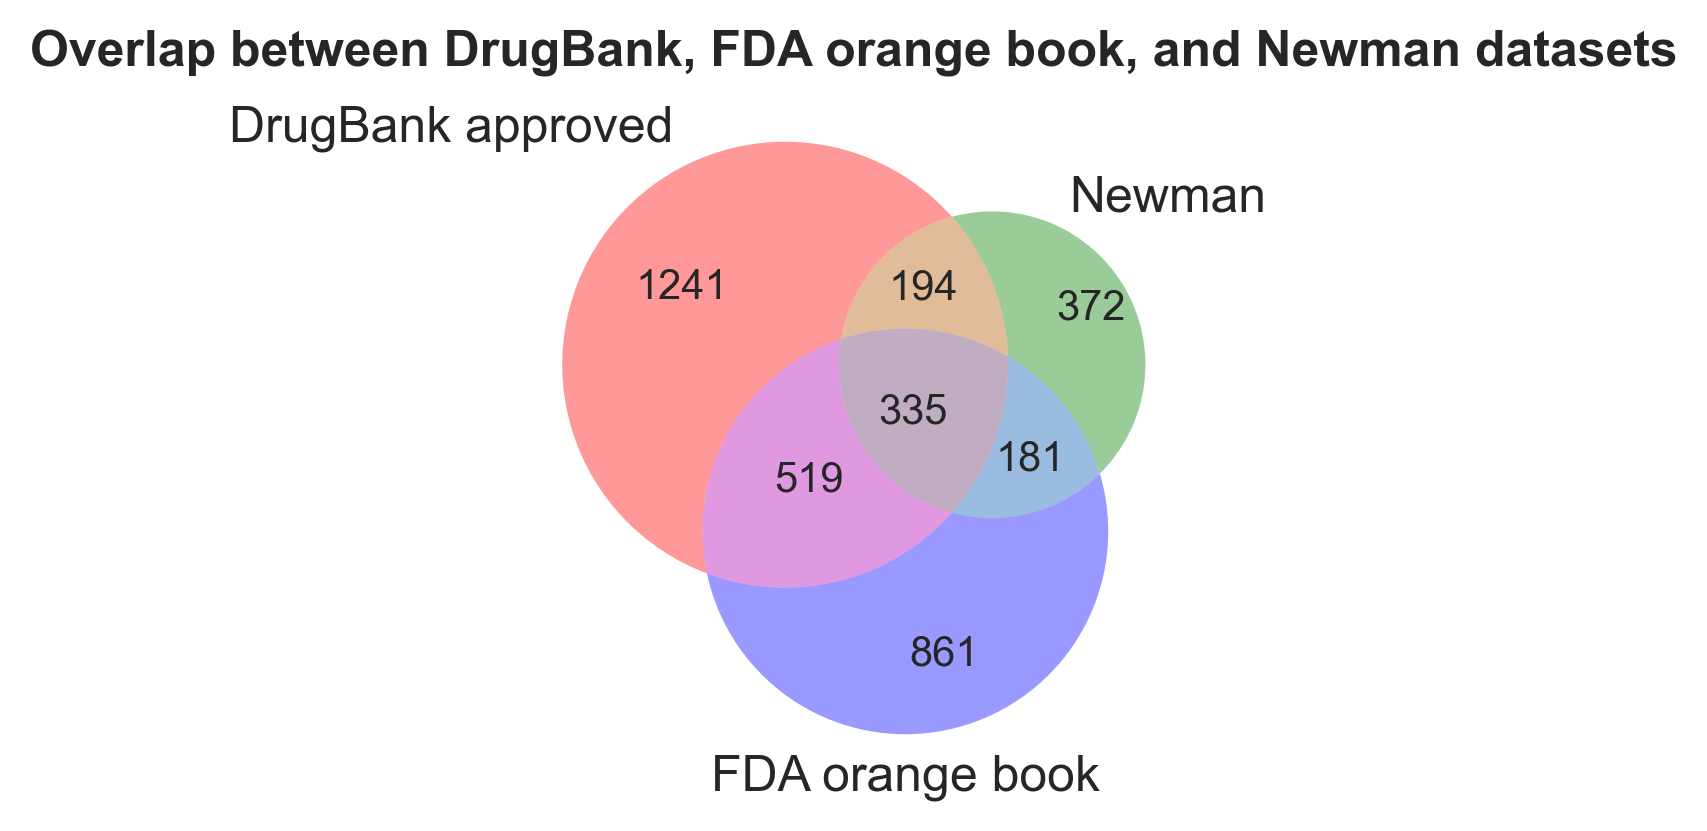

In [43]:
plt.figure(dpi=300, figsize=([3, 3]))
v = venn3(
    [
        drugbank_inchikeys,
        synthethics_inchikeys.union(natural_products_newman_inchikeys),
        fda_approved_inchikeys,
    ],
    set_labels=("DrugBank approved", "Newman", "FDA orange book"),
)
plt.title(
    "Overlap between DrugBank, FDA orange book, and Newman datasets",
    fontsize=12,
    fontweight="bold",
)

plt.show()

In [44]:
dump_df = pd.DataFrame(
    [
        {
            "type": "np"
            if inchikey in natural_products_newman_inchikeys
            else "synthetic"
            if inchikey in synthethics_inchikeys
            else "-",
            "name": synthethics_inchikeys_dict[inchikey]
            if inchikey in synthethics_inchikeys_dict
            else natural_products_inchikeys_dict[inchikey],
            "smiles": get_compounds(inchikey, "inchikey")[0].canonical_smiles,
        }
        for inchikey in tqdm(
            natural_products_newman_inchikeys.intersection(
                phytochemicals_inchikey
            ).union(synthethics_inchikeys.intersection(phytochemicals_inchikey))
        )
    ]
)

dump_df["Mol Image"] = [Chem.MolFromSmiles(s) for s in dump_df["smiles"]]

PandasTools.SaveXlsxFromFrame(
    dump_df, "overlapping_phytochemicals.xlsx", molCol="Mol Image"
)

100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


### Murcko scaffolds

In [45]:
def get_murcko_scaffolds(smiles, skipped):
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped += 1

    return Chem.MolToSmiles(GetScaffoldForMol(molecule))


synthethics_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(synthetics_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
synthethics_murcko = {smiles for smiles in synthethics_murcko if smiles}

natural_products_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(natural_products_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
natural_products_murcko = {smiles for smiles in natural_products_murcko if smiles}

phytochemicals_murcko = {
    get_murcko_scaffolds(smiles, skipped) for smiles in tqdm(smiles_to_pubchem.keys())
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_murcko = {
    murcko
    for murcko in phytochemicals_murcko
    if murcko in synthethics_murcko or murcko in natural_products_murcko
    if murcko
}

# Remove the empty ones filtered out before
phytochemicals_murcko = {smiles for smiles in phytochemicals_murcko if smiles}

100%|██████████| 69954/69954 [00:20<00:00, 3391.77it/s]


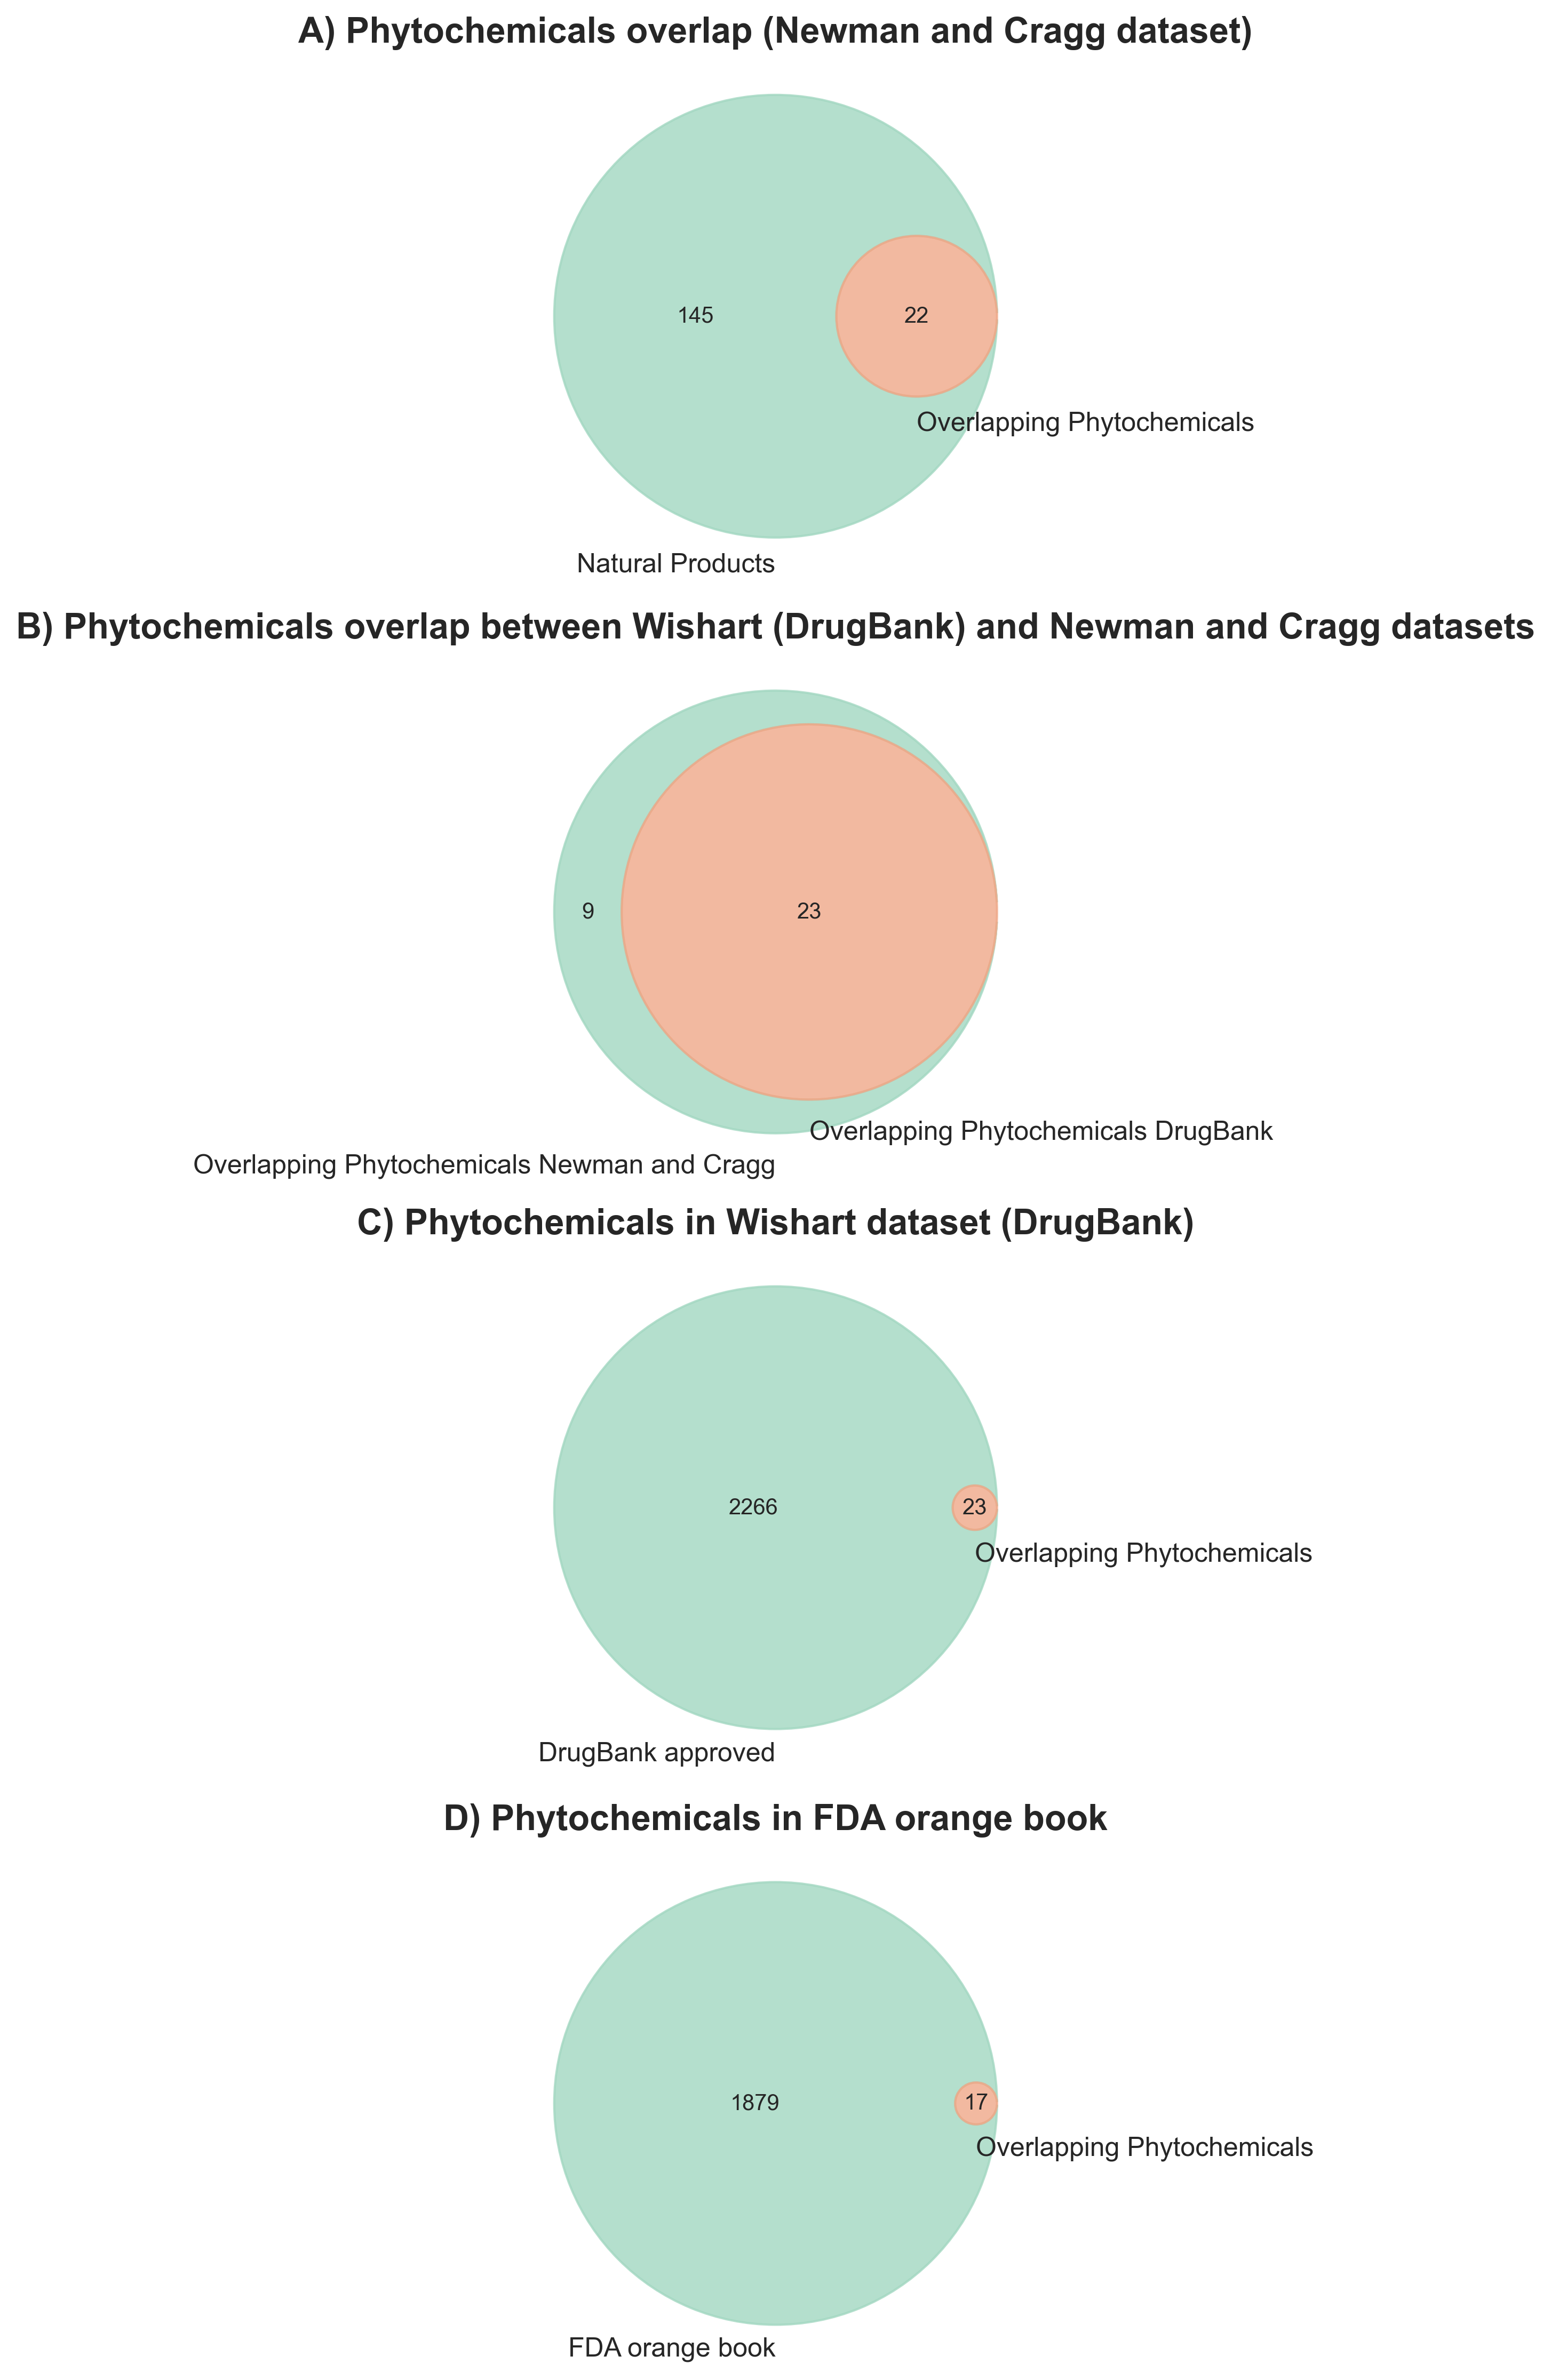

In [46]:
plt.figure(dpi=300, figsize=([15, 15]))

plt.subplots_adjust(wspace=1)

"""Plot 1. Phytochemicals in NP Newman and Cragg"""

plt.subplot(4, 1, 1)

ax = plt.gca()
v = venn2(
    [
        natural_products_newman_inchikeys,
        {
            inchikey
            for inchikey in phytochemicals_inchikey
            if inchikey in natural_products_newman_inchikeys
        },
    ],
    set_labels=("Natural Products", "Overlapping Phytochemicals"),
    alpha=0.8,
)

plt.title(
    "A) Phytochemicals overlap (Newman and Cragg dataset)",
    fontweight="bold",
    fontsize=16,
)

# Remove the count for phytochemicals that are not in the other sets since we remove that
v.get_label_by_id("01").set_text("")
v.get_patch_by_id("10").set_color("#a2d7c1")
v.get_patch_by_id("11").set_color("#efa888")

"""Plot 2. Newman vs. DrugBank"""
plt.subplot(4, 1, 2)

v = venn2(
    [
        phytochemicals_inchikey,
        {
            inchikey
            for inchikey in phytochemicals_inchikey
            if inchikey in drugbank_inchikeys
        },
    ],
    set_labels=(
        "Overlapping Phytochemicals Newman and Cragg",
        "Overlapping Phytochemicals DrugBank",
    ),
    alpha=0.8,
)
v.get_label_by_id("01").set_text("")
v.get_patch_by_id("10").set_color("#a2d7c1")
v.get_patch_by_id("11").set_color("#efa888")

plt.title(
    "B) Phytochemicals overlap between Wishart (DrugBank) and Newman and Cragg datasets",
    fontweight="bold",
    fontsize=16,
)

"""Plot 3. Phytochemicals overlapping in the two datasets"""
plt.subplot(4, 1, 3)
v = venn2(
    [
        drugbank_inchikeys,
        {
            inchikey
            for inchikey in phytochemicals_inchikey
            if inchikey in drugbank_inchikeys
        },
    ],
    set_labels=("DrugBank approved", "Overlapping Phytochemicals"),
    alpha=0.8,
)
# plt.title('Phytochemicals that are approved-drugs on the DrugBank dataset', fontsize=10, fontweight='bold')
v.get_label_by_id("010").set_text("")
v.get_patch_by_id("10").set_color("#a2d7c1")
v.get_patch_by_id("11").set_color("#efa888")


plt.title(
    "C) Phytochemicals in Wishart dataset (DrugBank)", fontweight="bold", fontsize=16
)


"""Plot 4. Phytochemicals overlapping in FDA orange book"""
plt.subplot(4, 1, 4)
v = venn2(
    [
        fda_approved_inchikeys,
        {
            inchikey
            for inchikey in phytochemicals_inchikey
            if inchikey in fda_approved_inchikeys
        },
    ],
    set_labels=("FDA orange book", "Overlapping Phytochemicals"),
    alpha=0.8,
)
# plt.title('Phytochemicals that are approved-drugs on the DrugBank dataset', fontsize=10, fontweight='bold')
v.get_label_by_id("010").set_text("")
v.get_patch_by_id("10").set_color("#a2d7c1")
v.get_patch_by_id("11").set_color("#efa888")


plt.title("D) Phytochemicals in FDA orange book", fontweight="bold", fontsize=16)

plt.tight_layout()
plt.savefig(
    f"supplementary_figure_approved_drugs_phytochemicals.png", bbox_inches="tight"
)
plt.show()

Scaffolds in all the three sets

In [47]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in synthethics_murcko.intersection(natural_products_murcko).intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=4,
#     subImgSize=(200,200),
# )

Scaffolds in NPs overlapping with phytochemicals

In [48]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in natural_products_murcko.intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=8,
#     subImgSize=(200,200),
# )

Scaffolds in Synthetics subset overlapping with phytochemicals

In [49]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in synthethics_murcko.intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=8,
#     subImgSize=(200,200),
#     maxMols=100,
# )